### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料集，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Import Necessary Libraries

In [1]:
import math
import tqdm
import random
import matplotlib.pyplot as plt
from typing import List
from collections import Counter

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# 讀取資料
# Penn TreeBank dataset
with open("ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [3]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [4]:
# 定義資料前處理函式
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[List[str]]):
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
            # hint: 請計算字詞頻率
            counter.update(sentence)
            processed_sentence.append(sentence)
    
        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys())}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt
        
        # 將文本轉為ID形式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if not self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            self.word_frequency = dict(counter.items())
            print(f"After subsampling: {self.total_num_words} words")
        
        # hint: 移除空字串
        self.processed_corpus = [line for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        # following original paper: https://arxiv.org/abs/1310.4546
        p_drop = 1.0 - math.sqrt(self.t / (self.word_frequency[self.idx2word[idx]] / self.total_num_words))
        
        return random.random() < (1 - p_drop)


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 885720 words
After subsampling: 511580 words


### 定義Skip-gram使用的Dataset與collate function

In [5]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx]
        
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2 * self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文(考慮window_size)
            all_contexts += line[self.window_size:-self.window_size]

            targets = []
            for idx in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                indices = list(range(idx - self.window_size, idx + self.window_size + 1))
                indices.remove(idx)
                all_targets.append([line[i] for i in indices])

        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word] ** 0.75 for word in self.word2freq]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        for targets in self.all_targets:
            negatives = []
            while len(negatives) < self.num_negatives:
                neg_candidate = random.choices(population, sampling_weights)[0]
                neg_cnadidate = self.word2idx[cur_exists_words[neg_candidate]]
                if neg_candidate not in targets:
                    negatives.append(neg_candidate)
            all_negatives.append(negatives)
        
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        target_negative += [target + negative]
        labels += [[1] * len(target) + [0] * len(negative)]
        contexts += [context]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

### 定義Skip-gram模型

In [6]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = self.in_embedding(contexts)
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = torch.matmul(v.unsqueeze(1), u.permute(0,2,1))
        
        return pred.squeeze(1)

### 訓練

In [7]:
# Define hyperparameters
use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)  # 學員可以自行選用optimizer
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, 1, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)

In [8]:
# Start training
lst_loss = []
model.train()
for ep in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0
    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred, labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {ep + 1}/{num_epochs}, Batch: {i + 1}/{len(dataset) / batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {ep + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")

    lst_loss.append(batch_loss/i)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Batch: 501/836.9296875 Loss: 0.97601


  1%|          | 1/100 [00:03<06:25,  3.89s/it]

Epoch: 1/100, Loss: 0.72939
Epoch: 2/100, Batch: 501/836.9296875 Loss: 0.28657


  2%|▏         | 2/100 [00:07<06:20,  3.89s/it]

Epoch: 2/100, Loss: 0.28172
Epoch: 3/100, Batch: 501/836.9296875 Loss: 0.25316


  3%|▎         | 3/100 [00:11<06:22,  3.94s/it]

Epoch: 3/100, Loss: 0.25422
Epoch: 4/100, Batch: 501/836.9296875 Loss: 0.24335


  4%|▍         | 4/100 [00:15<06:14,  3.90s/it]

Epoch: 4/100, Loss: 0.24502
Epoch: 5/100, Batch: 501/836.9296875 Loss: 0.23861


  5%|▌         | 5/100 [00:19<06:09,  3.89s/it]

Epoch: 5/100, Loss: 0.24056
Epoch: 6/100, Batch: 501/836.9296875 Loss: 0.23604


  6%|▌         | 6/100 [00:23<06:11,  3.95s/it]

Epoch: 6/100, Loss: 0.23803
Epoch: 7/100, Batch: 501/836.9296875 Loss: 0.23475


  7%|▋         | 7/100 [00:27<06:04,  3.91s/it]

Epoch: 7/100, Loss: 0.23637
Epoch: 8/100, Batch: 501/836.9296875 Loss: 0.23296


  8%|▊         | 8/100 [00:31<05:57,  3.89s/it]

Epoch: 8/100, Loss: 0.23520
Epoch: 9/100, Batch: 501/836.9296875 Loss: 0.23219


  9%|▉         | 9/100 [00:35<05:58,  3.94s/it]

Epoch: 9/100, Loss: 0.23427
Epoch: 10/100, Batch: 501/836.9296875 Loss: 0.23195


 10%|█         | 10/100 [00:39<05:52,  3.92s/it]

Epoch: 10/100, Loss: 0.23374
Epoch: 11/100, Batch: 501/836.9296875 Loss: 0.23115


 11%|█         | 11/100 [00:43<05:47,  3.90s/it]

Epoch: 11/100, Loss: 0.23304
Epoch: 12/100, Batch: 501/836.9296875 Loss: 0.23074


 12%|█▏        | 12/100 [00:47<05:47,  3.95s/it]

Epoch: 12/100, Loss: 0.23273
Epoch: 13/100, Batch: 501/836.9296875 Loss: 0.23061


 13%|█▎        | 13/100 [00:50<05:41,  3.92s/it]

Epoch: 13/100, Loss: 0.23243
Epoch: 14/100, Batch: 501/836.9296875 Loss: 0.23007


 14%|█▍        | 14/100 [00:54<05:36,  3.91s/it]

Epoch: 14/100, Loss: 0.23208
Epoch: 15/100, Batch: 501/836.9296875 Loss: 0.23005


 15%|█▌        | 15/100 [00:58<05:36,  3.95s/it]

Epoch: 15/100, Loss: 0.23189
Epoch: 16/100, Batch: 501/836.9296875 Loss: 0.22954


 16%|█▌        | 16/100 [01:02<05:30,  3.93s/it]

Epoch: 16/100, Loss: 0.23167
Epoch: 17/100, Batch: 501/836.9296875 Loss: 0.22953


 17%|█▋        | 17/100 [01:06<05:24,  3.91s/it]

Epoch: 17/100, Loss: 0.23145
Epoch: 18/100, Batch: 501/836.9296875 Loss: 0.22928


 18%|█▊        | 18/100 [01:10<05:23,  3.95s/it]

Epoch: 18/100, Loss: 0.23140
Epoch: 19/100, Batch: 501/836.9296875 Loss: 0.22935


 19%|█▉        | 19/100 [01:14<05:17,  3.92s/it]

Epoch: 19/100, Loss: 0.23121
Epoch: 20/100, Batch: 501/836.9296875 Loss: 0.22959


 20%|██        | 20/100 [01:18<05:14,  3.93s/it]

Epoch: 20/100, Loss: 0.23114
Epoch: 21/100, Batch: 501/836.9296875 Loss: 0.22923


 21%|██        | 21/100 [01:22<05:13,  3.96s/it]

Epoch: 21/100, Loss: 0.23089
Epoch: 22/100, Batch: 501/836.9296875 Loss: 0.22891


 22%|██▏       | 22/100 [01:26<05:05,  3.92s/it]

Epoch: 22/100, Loss: 0.23088
Epoch: 23/100, Batch: 501/836.9296875 Loss: 0.22867


 23%|██▎       | 23/100 [01:30<04:59,  3.89s/it]

Epoch: 23/100, Loss: 0.23085
Epoch: 24/100, Batch: 501/836.9296875 Loss: 0.22884


 24%|██▍       | 24/100 [01:34<04:59,  3.94s/it]

Epoch: 24/100, Loss: 0.23075
Epoch: 25/100, Batch: 501/836.9296875 Loss: 0.22846


 25%|██▌       | 25/100 [01:38<04:53,  3.92s/it]

Epoch: 25/100, Loss: 0.23077
Epoch: 26/100, Batch: 501/836.9296875 Loss: 0.22828


 26%|██▌       | 26/100 [01:41<04:48,  3.90s/it]

Epoch: 26/100, Loss: 0.23064
Epoch: 27/100, Batch: 501/836.9296875 Loss: 0.22871


 27%|██▋       | 27/100 [01:45<04:47,  3.94s/it]

Epoch: 27/100, Loss: 0.23062
Epoch: 28/100, Batch: 501/836.9296875 Loss: 0.22855


 28%|██▊       | 28/100 [01:49<04:42,  3.93s/it]

Epoch: 28/100, Loss: 0.23061
Epoch: 29/100, Batch: 501/836.9296875 Loss: 0.22825


 29%|██▉       | 29/100 [01:53<04:37,  3.91s/it]

Epoch: 29/100, Loss: 0.23052
Epoch: 30/100, Batch: 501/836.9296875 Loss: 0.22853


 30%|███       | 30/100 [01:57<04:36,  3.96s/it]

Epoch: 30/100, Loss: 0.23049
Epoch: 31/100, Batch: 501/836.9296875 Loss: 0.22845


 31%|███       | 31/100 [02:01<04:31,  3.93s/it]

Epoch: 31/100, Loss: 0.23033
Epoch: 32/100, Batch: 501/836.9296875 Loss: 0.22875


 32%|███▏      | 32/100 [02:05<04:25,  3.90s/it]

Epoch: 32/100, Loss: 0.23042
Epoch: 33/100, Batch: 501/836.9296875 Loss: 0.22855


 33%|███▎      | 33/100 [02:09<04:24,  3.95s/it]

Epoch: 33/100, Loss: 0.23038
Epoch: 34/100, Batch: 501/836.9296875 Loss: 0.22848


 34%|███▍      | 34/100 [02:13<04:19,  3.92s/it]

Epoch: 34/100, Loss: 0.23030
Epoch: 35/100, Batch: 501/836.9296875 Loss: 0.22851


 35%|███▌      | 35/100 [02:17<04:13,  3.90s/it]

Epoch: 35/100, Loss: 0.23033
Epoch: 36/100, Batch: 501/836.9296875 Loss: 0.22817


 36%|███▌      | 36/100 [02:21<04:12,  3.94s/it]

Epoch: 36/100, Loss: 0.23022
Epoch: 37/100, Batch: 501/836.9296875 Loss: 0.22830


 37%|███▋      | 37/100 [02:25<04:06,  3.91s/it]

Epoch: 37/100, Loss: 0.23018
Epoch: 38/100, Batch: 501/836.9296875 Loss: 0.22834


 38%|███▊      | 38/100 [02:28<04:00,  3.88s/it]

Epoch: 38/100, Loss: 0.23021
Epoch: 39/100, Batch: 501/836.9296875 Loss: 0.22807


 39%|███▉      | 39/100 [02:33<04:00,  3.94s/it]

Epoch: 39/100, Loss: 0.23016
Epoch: 40/100, Batch: 501/836.9296875 Loss: 0.22856


 40%|████      | 40/100 [02:36<03:55,  3.92s/it]

Epoch: 40/100, Loss: 0.23013
Epoch: 41/100, Batch: 501/836.9296875 Loss: 0.22833


 41%|████      | 41/100 [02:40<03:49,  3.89s/it]

Epoch: 41/100, Loss: 0.23014
Epoch: 42/100, Batch: 501/836.9296875 Loss: 0.22845


 42%|████▏     | 42/100 [02:44<03:48,  3.95s/it]

Epoch: 42/100, Loss: 0.23022
Epoch: 43/100, Batch: 501/836.9296875 Loss: 0.22839


 43%|████▎     | 43/100 [02:48<03:43,  3.92s/it]

Epoch: 43/100, Loss: 0.23006
Epoch: 44/100, Batch: 501/836.9296875 Loss: 0.22834


 44%|████▍     | 44/100 [02:52<03:37,  3.89s/it]

Epoch: 44/100, Loss: 0.23014
Epoch: 45/100, Batch: 501/836.9296875 Loss: 0.22841


 45%|████▌     | 45/100 [02:56<03:35,  3.92s/it]

Epoch: 45/100, Loss: 0.22999
Epoch: 46/100, Batch: 501/836.9296875 Loss: 0.22878


 46%|████▌     | 46/100 [03:00<03:30,  3.90s/it]

Epoch: 46/100, Loss: 0.23007
Epoch: 47/100, Batch: 501/836.9296875 Loss: 0.22810


 47%|████▋     | 47/100 [03:04<03:27,  3.91s/it]

Epoch: 47/100, Loss: 0.23004
Epoch: 48/100, Batch: 501/836.9296875 Loss: 0.22776


 48%|████▊     | 48/100 [03:08<03:27,  4.00s/it]

Epoch: 48/100, Loss: 0.22991
Epoch: 49/100, Batch: 501/836.9296875 Loss: 0.22778


 49%|████▉     | 49/100 [03:12<03:22,  3.97s/it]

Epoch: 49/100, Loss: 0.23002
Epoch: 50/100, Batch: 501/836.9296875 Loss: 0.22779


 50%|█████     | 50/100 [03:16<03:16,  3.93s/it]

Epoch: 50/100, Loss: 0.22990
Epoch: 51/100, Batch: 501/836.9296875 Loss: 0.22800


 51%|█████     | 51/100 [03:20<03:14,  3.96s/it]

Epoch: 51/100, Loss: 0.22996
Epoch: 52/100, Batch: 501/836.9296875 Loss: 0.22790


 52%|█████▏    | 52/100 [03:24<03:09,  3.94s/it]

Epoch: 52/100, Loss: 0.22993
Epoch: 53/100, Batch: 501/836.9296875 Loss: 0.22791


 53%|█████▎    | 53/100 [03:27<03:03,  3.91s/it]

Epoch: 53/100, Loss: 0.22991
Epoch: 54/100, Batch: 501/836.9296875 Loss: 0.22764


 54%|█████▍    | 54/100 [03:32<03:02,  3.96s/it]

Epoch: 54/100, Loss: 0.22983
Epoch: 55/100, Batch: 501/836.9296875 Loss: 0.22843


 55%|█████▌    | 55/100 [03:35<02:56,  3.92s/it]

Epoch: 55/100, Loss: 0.22995
Epoch: 56/100, Batch: 501/836.9296875 Loss: 0.22836


 56%|█████▌    | 56/100 [03:39<02:51,  3.90s/it]

Epoch: 56/100, Loss: 0.22982
Epoch: 57/100, Batch: 501/836.9296875 Loss: 0.22842


 57%|█████▋    | 57/100 [03:43<02:49,  3.94s/it]

Epoch: 57/100, Loss: 0.22988
Epoch: 58/100, Batch: 501/836.9296875 Loss: 0.22776


 58%|█████▊    | 58/100 [03:47<02:45,  3.93s/it]

Epoch: 58/100, Loss: 0.22981
Epoch: 59/100, Batch: 501/836.9296875 Loss: 0.22785


 59%|█████▉    | 59/100 [03:51<02:41,  3.93s/it]

Epoch: 59/100, Loss: 0.22983
Epoch: 60/100, Batch: 501/836.9296875 Loss: 0.22816


 60%|██████    | 60/100 [03:55<02:38,  3.97s/it]

Epoch: 60/100, Loss: 0.22977
Epoch: 61/100, Batch: 501/836.9296875 Loss: 0.22767


 61%|██████    | 61/100 [03:59<02:33,  3.94s/it]

Epoch: 61/100, Loss: 0.22985
Epoch: 62/100, Batch: 501/836.9296875 Loss: 0.22820


 62%|██████▏   | 62/100 [04:03<02:29,  3.92s/it]

Epoch: 62/100, Loss: 0.22983
Epoch: 63/100, Batch: 501/836.9296875 Loss: 0.22788


 63%|██████▎   | 63/100 [04:07<02:26,  3.96s/it]

Epoch: 63/100, Loss: 0.22980
Epoch: 64/100, Batch: 501/836.9296875 Loss: 0.22771


 64%|██████▍   | 64/100 [04:11<02:20,  3.91s/it]

Epoch: 64/100, Loss: 0.22978
Epoch: 65/100, Batch: 501/836.9296875 Loss: 0.22766


 65%|██████▌   | 65/100 [04:15<02:15,  3.88s/it]

Epoch: 65/100, Loss: 0.22982
Epoch: 66/100, Batch: 501/836.9296875 Loss: 0.22775


 66%|██████▌   | 66/100 [04:19<02:13,  3.92s/it]

Epoch: 66/100, Loss: 0.22975
Epoch: 67/100, Batch: 501/836.9296875 Loss: 0.22783


 67%|██████▋   | 67/100 [04:22<02:08,  3.90s/it]

Epoch: 67/100, Loss: 0.22977
Epoch: 68/100, Batch: 501/836.9296875 Loss: 0.22746


 68%|██████▊   | 68/100 [04:27<02:06,  3.94s/it]

Epoch: 68/100, Loss: 0.22978
Epoch: 69/100, Batch: 501/836.9296875 Loss: 0.22771


 69%|██████▉   | 69/100 [04:30<02:01,  3.91s/it]

Epoch: 69/100, Loss: 0.22969
Epoch: 70/100, Batch: 501/836.9296875 Loss: 0.22784


 70%|███████   | 70/100 [04:34<01:56,  3.87s/it]

Epoch: 70/100, Loss: 0.22976
Epoch: 71/100, Batch: 501/836.9296875 Loss: 0.22736


 71%|███████   | 71/100 [04:38<01:53,  3.91s/it]

Epoch: 71/100, Loss: 0.22977
Epoch: 72/100, Batch: 501/836.9296875 Loss: 0.22767


 72%|███████▏  | 72/100 [04:42<01:48,  3.89s/it]

Epoch: 72/100, Loss: 0.22965
Epoch: 73/100, Batch: 501/836.9296875 Loss: 0.22782


 73%|███████▎  | 73/100 [04:46<01:44,  3.87s/it]

Epoch: 73/100, Loss: 0.22976
Epoch: 74/100, Batch: 501/836.9296875 Loss: 0.22803


 74%|███████▍  | 74/100 [04:50<01:42,  3.93s/it]

Epoch: 74/100, Loss: 0.22968
Epoch: 75/100, Batch: 501/836.9296875 Loss: 0.22765


 75%|███████▌  | 75/100 [04:54<01:37,  3.90s/it]

Epoch: 75/100, Loss: 0.22971
Epoch: 76/100, Batch: 501/836.9296875 Loss: 0.22781


 76%|███████▌  | 76/100 [04:57<01:32,  3.87s/it]

Epoch: 76/100, Loss: 0.22968
Epoch: 77/100, Batch: 501/836.9296875 Loss: 0.22797


 77%|███████▋  | 77/100 [05:02<01:30,  3.92s/it]

Epoch: 77/100, Loss: 0.22964
Epoch: 78/100, Batch: 501/836.9296875 Loss: 0.22740


 78%|███████▊  | 78/100 [05:05<01:25,  3.89s/it]

Epoch: 78/100, Loss: 0.22967
Epoch: 79/100, Batch: 501/836.9296875 Loss: 0.22765


 79%|███████▉  | 79/100 [05:09<01:21,  3.86s/it]

Epoch: 79/100, Loss: 0.22967
Epoch: 80/100, Batch: 501/836.9296875 Loss: 0.22811


 80%|████████  | 80/100 [05:13<01:18,  3.92s/it]

Epoch: 80/100, Loss: 0.22969
Epoch: 81/100, Batch: 501/836.9296875 Loss: 0.22745


 81%|████████  | 81/100 [05:17<01:14,  3.90s/it]

Epoch: 81/100, Loss: 0.22974
Epoch: 82/100, Batch: 501/836.9296875 Loss: 0.22721


 82%|████████▏ | 82/100 [05:21<01:09,  3.87s/it]

Epoch: 82/100, Loss: 0.22966
Epoch: 83/100, Batch: 501/836.9296875 Loss: 0.22799


 83%|████████▎ | 83/100 [05:25<01:06,  3.93s/it]

Epoch: 83/100, Loss: 0.22965
Epoch: 84/100, Batch: 501/836.9296875 Loss: 0.22747


 84%|████████▍ | 84/100 [05:29<01:02,  3.89s/it]

Epoch: 84/100, Loss: 0.22967
Epoch: 85/100, Batch: 501/836.9296875 Loss: 0.22737


 85%|████████▌ | 85/100 [05:33<00:58,  3.87s/it]

Epoch: 85/100, Loss: 0.22963
Epoch: 86/100, Batch: 501/836.9296875 Loss: 0.22740


 86%|████████▌ | 86/100 [05:36<00:54,  3.90s/it]

Epoch: 86/100, Loss: 0.22955
Epoch: 87/100, Batch: 501/836.9296875 Loss: 0.22796


 87%|████████▋ | 87/100 [05:40<00:50,  3.88s/it]

Epoch: 87/100, Loss: 0.22970
Epoch: 88/100, Batch: 501/836.9296875 Loss: 0.22742


 88%|████████▊ | 88/100 [05:44<00:46,  3.86s/it]

Epoch: 88/100, Loss: 0.22967
Epoch: 89/100, Batch: 501/836.9296875 Loss: 0.22792


 89%|████████▉ | 89/100 [05:48<00:43,  3.91s/it]

Epoch: 89/100, Loss: 0.22959
Epoch: 90/100, Batch: 501/836.9296875 Loss: 0.22777


 90%|█████████ | 90/100 [05:52<00:38,  3.90s/it]

Epoch: 90/100, Loss: 0.22963
Epoch: 91/100, Batch: 501/836.9296875 Loss: 0.22759


 91%|█████████ | 91/100 [05:56<00:34,  3.86s/it]

Epoch: 91/100, Loss: 0.22967
Epoch: 92/100, Batch: 501/836.9296875 Loss: 0.22754


 92%|█████████▏| 92/100 [06:00<00:31,  3.91s/it]

Epoch: 92/100, Loss: 0.22961
Epoch: 93/100, Batch: 501/836.9296875 Loss: 0.22774


 93%|█████████▎| 93/100 [06:04<00:27,  3.88s/it]

Epoch: 93/100, Loss: 0.22962
Epoch: 94/100, Batch: 501/836.9296875 Loss: 0.22743


 94%|█████████▍| 94/100 [06:07<00:23,  3.86s/it]

Epoch: 94/100, Loss: 0.22962
Epoch: 95/100, Batch: 501/836.9296875 Loss: 0.22733


 95%|█████████▌| 95/100 [06:11<00:19,  3.89s/it]

Epoch: 95/100, Loss: 0.22955
Epoch: 96/100, Batch: 501/836.9296875 Loss: 0.22780


 96%|█████████▌| 96/100 [06:15<00:15,  3.86s/it]

Epoch: 96/100, Loss: 0.22962
Epoch: 97/100, Batch: 501/836.9296875 Loss: 0.22772


 97%|█████████▋| 97/100 [06:19<00:11,  3.84s/it]

Epoch: 97/100, Loss: 0.22957
Epoch: 98/100, Batch: 501/836.9296875 Loss: 0.22707


 98%|█████████▊| 98/100 [06:23<00:07,  3.89s/it]

Epoch: 98/100, Loss: 0.22956
Epoch: 99/100, Batch: 501/836.9296875 Loss: 0.22823


 99%|█████████▉| 99/100 [06:27<00:03,  3.87s/it]

Epoch: 99/100, Loss: 0.22955
Epoch: 100/100, Batch: 501/836.9296875 Loss: 0.22785


100%|██████████| 100/100 [06:31<00:00,  3.91s/it]

Epoch: 100/100, Loss: 0.22959


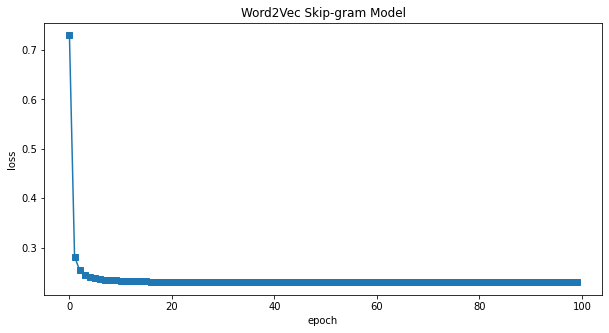

In [9]:
# visualization loss
plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [10]:
# 計算字詞相似度
def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k + 1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.391: barrel.
cosine sim=0.347: fought.
cosine sim=0.336: ahmanson.
cosine sim=0.332: laundering.
